In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
from fractions import Fraction
import matplotlib.pyplot as plt
import seaborn as sns



warnings.filterwarnings('ignore')

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [4]:
education_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [5]:
column_list = list(education_df.columns.values)
column_list.pop(2)
column_list.pop(1)
column_list.pop(0)

# interpolate data by states
allstates = education_df["STATE"].unique()

for state in allstates:
    education_df.loc[education_df["STATE"] == state, column_list] = education_df.loc[education_df["STATE"] == state, column_list].interpolate()

# drop the null values after interpolation
education_df.dropna(inplace=True)

## 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

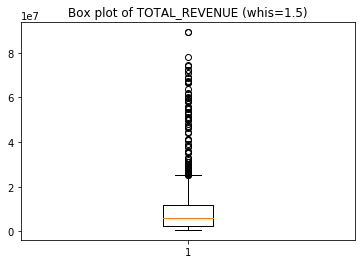

In [6]:
plt.boxplot(education_df["TOTAL_REVENUE"])
plt.title("Box plot of TOTAL_REVENUE (whis=1.5)")
plt.show()

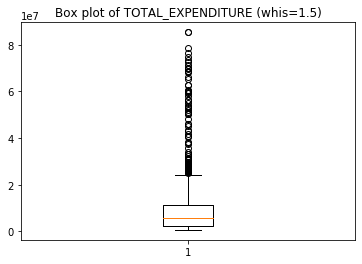

In [7]:
plt.boxplot(education_df["TOTAL_EXPENDITURE"])
plt.title("Box plot of TOTAL_EXPENDITURE (whis=1.5)")
plt.show()

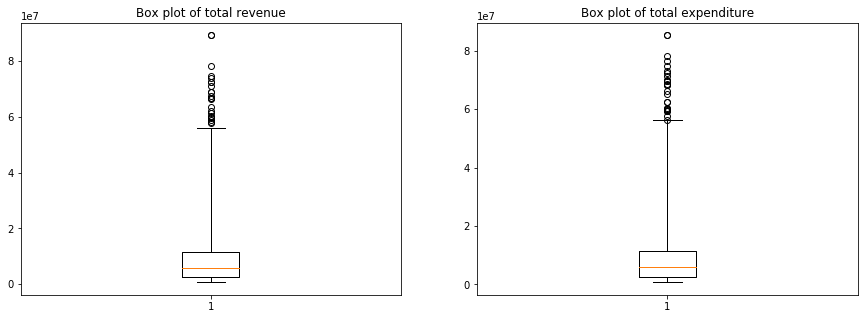

In [30]:
#same plots as above, next to each other with whis = 5.
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(education_df["TOTAL_REVENUE"], whis = 5)
plt.title("Box plot of total revenue")

plt.subplot(1,2,2)
plt.boxplot(education_df["TOTAL_EXPENDITURE"], whis = 5)
plt.title("Box plot of total expenditure")
plt.show()

## 2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

In [31]:
from scipy.stats.mstats import winsorize

# We apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 90th percentile. 
# We have winsorized versions for both our variables of interest.

winsorized_rev = winsorize(education_df["TOTAL_REVENUE"], (0, 0.05))

winsorized_exp = winsorize(education_df["TOTAL_EXPENDITURE"], (0, 0.05))

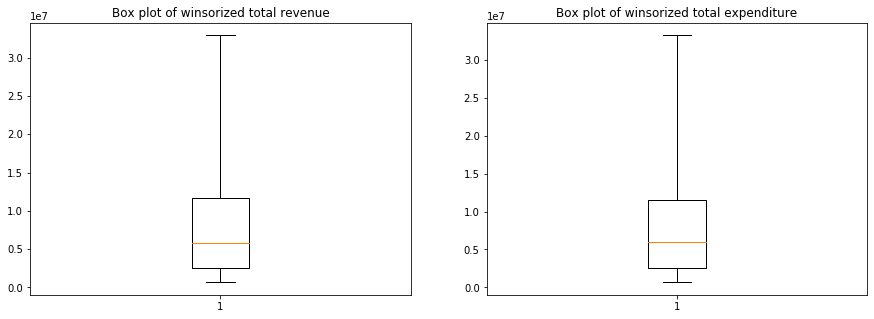

In [32]:
# Lets view how the outliers look now:

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(winsorized_rev, whis = 5)
plt.title("Box plot of winsorized total revenue")

plt.subplot(1,2,2)
plt.boxplot(winsorized_exp, whis = 5)
plt.title("Box plot of winsorized total expenditure")
plt.show()

## 3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.


In [33]:
education_df['DEFICIT'] = education_df.TOTAL_REVENUE - education_df.TOTAL_EXPENDITURE

Text(0.5, 1.0, 'Box plot of budget deficit')

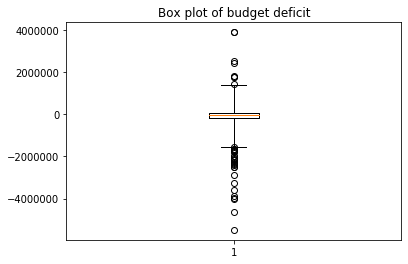

In [34]:
plt.boxplot(education_df.DEFICIT, whis = 5) #what's the best way to choose whisker size?
plt.title("Box plot of budget deficit")

In [35]:
budget_winsorized = winsorize(education_df.DEFICIT, (0.05, 0.05))

Text(0.5, 1.0, 'Box plot of budget deficit')

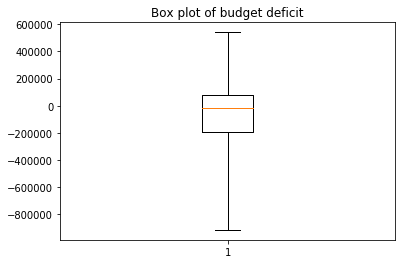

In [36]:
plt.boxplot(budget_winsorized, whis = 5)
plt.title("Box plot of budget deficit")

## 4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. But this time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.


In [38]:
# take difference between winsorized volums  oood
education_df['DEFICIT2'] = winsorized_rev - winsorized_exp

Text(0.5, 1.0, 'Box plot of budget deficit 2')

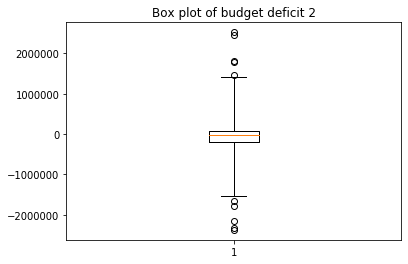

In [39]:
plt.boxplot(education_df.DEFICIT2, whis = 5)
plt.title("Box plot of budget deficit 2")

In [40]:
winsorized_budget2 = winsorize(education_df.DEFICIT2, (0.05, 0.05))

Text(0.5, 1.0, 'Box plot of budget deficit 2')

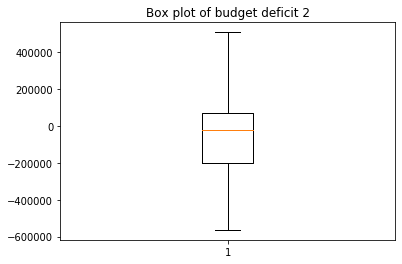

In [41]:
plt.boxplot(winsorized_budget2, whis = 5)
plt.title("Box plot of budget deficit 2")

## 4. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

In [43]:
pd.DataFrame({"original_budget": education_df.DEFICIT, "winsorized_budget1": budget_winsorized,
              "winsorized_budget2": winsorized_budget2}).describe()

,original_budget,winsorized_budget1,winsorized_budget2
count,1.046000e+03,1046.000000,1046.000000
mean,-8.971628e+04,-67121.217017,-42953.404398
std,6.065230e+05,324443.529605,251843.508358
min,-5.487742e+06,-913765.000000,-563852.000000
25%,-1.949450e+05,-194945.000000,-202135.250000
50%,-1.583400e+04,-15834.000000,-20112.500000
75%,7.736350e+04,77363.500000,72142.000000
max,3.897129e+06,540772.000000,508361.000000


For almost all critical statistics, the two variables differ substantially. For example:

The mean of the first variant is -67121.217017 whereas the mean of the second variant is 42953.404398.

The median of the first variant is -15834.000000 whereas the median of the second variant is -20112.500000.

The maximum of the first variant is 540772.000000 whereas the maximum of the second variant is 508361.00000.

From this we gather that outlier elimination strategy can greatly affect the statistics of the variables!